<a href="https://colab.research.google.com/github/tayfununal/Uniform-Autoencoder-with-Latent-Flow-Matching/blob/main/evaluations/celebA_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!git clone https://github.com/tayfununal/Uniform-Autoencoder-with-Latent-Flow-Matching.git

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torchvision.transforms as T
from torch import Tensor

from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
from PIL import Image

import os

print(os.getcwd())
%run /content/Uniform-Autoencoder-with-Latent-Flow-Matching/models/celebA_model.ipynb
%run /content/Uniform-Autoencoder-with-Latent-Flow-Matching/datasets/celebA_dataset.ipynb

plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [ ]:
import zipfile
import os

def unzip_to_data(zip_path, out_dir='./data'):
    os.makedirs(out_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(out_dir)
    print(f"Zip extracted: {out_dir}")

unzip_to_data('/content/drive/MyDrive/CelebA/list_attr_celeba.csv.zip')
unzip_to_data('/content/drive/MyDrive/CelebA/img_align_celeba.zip')
unzip_to_data('/content/drive/MyDrive/CelebA/list_eval_partition.csv.zip')

In [18]:
# Dataset
root_dir = './data/img_align_celeba/'
test_dataset  = CelebADataset(img_dir=root_dir, attr_path='./data/list_attr_celeba.csv', partition_path='./data/list_eval_partition.csv', mode='test')
test_loader  = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [19]:
# Create the results folder
os.makedirs("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/results/celebA", exist_ok=True)

name = '/content/Uniform-Autoencoder-with-Latent-Flow-Matching/results/celebA/UAE_CelebA'
model_eval = torch.load(name + '.model', weights_only=False, map_location='cpu')
model_eval.eval()

To_Uniform(
  (encoder): SimpleEncoder(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc): Sequential(
      (0): Linear(in_features=8192, out_features=2048, bias=True)
      (1): SiLU

# MSE on Test Set

In [20]:
X_test = next(iter(test_loader))

# Feed the test data into the model
with torch.no_grad():
    z, x_hat = model_eval(X_test)

# MSE Loss
mse_loss = nn.MSELoss()

# Compute the average MSE
mse = mse_loss(x_hat, X_test)

print("Test MSE:", mse.item())

# Create the results folder
os.makedirs("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/results/celebA", exist_ok=True)

# Create the results folder
file_path = "/content/Uniform-Autoencoder-with-Latent-Flow-Matching/results/celebA/test_mse.txt"
with open(file_path, "w") as f:
    f.write(f"Test MSE: {mse.item()}\n")

print(f"Test MSE results have been saved to the '/content/Uniform-Autoencoder-with-Latent-Flow-Matching/results/celebA' directory: {file_path}")

Test MSE: 0.0038922172971069813
Test MSE results have been saved to the '/content/Uniform-Autoencoder-with-Latent-Flow-Matching/results/celebA' directory: /content/Uniform-Autoencoder-with-Latent-Flow-Matching/results/celebA/test_mse.txt


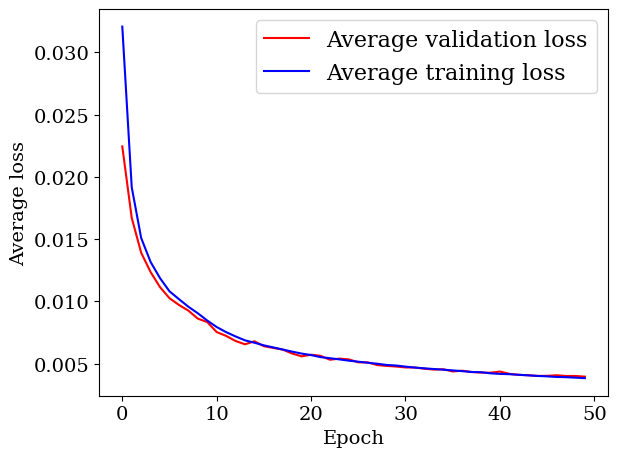

In [21]:
# Load the training and validation losses

losses = np.loadtxt("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/results/celebA/losses.csv", delimiter=",", skiprows=1)
train_losses = losses[:, 0]
val_losses = losses[:, 1]

# Create a plot
plt.plot(val_losses, label="Average validation loss", c="red")
plt.plot(train_losses, label="Average training loss", c="blue")

plt.xlabel("Epoch")
plt.ylabel("Average loss")
plt.legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.savefig("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/results/celebA/average_losses_per_epoch.pdf")
plt.show()


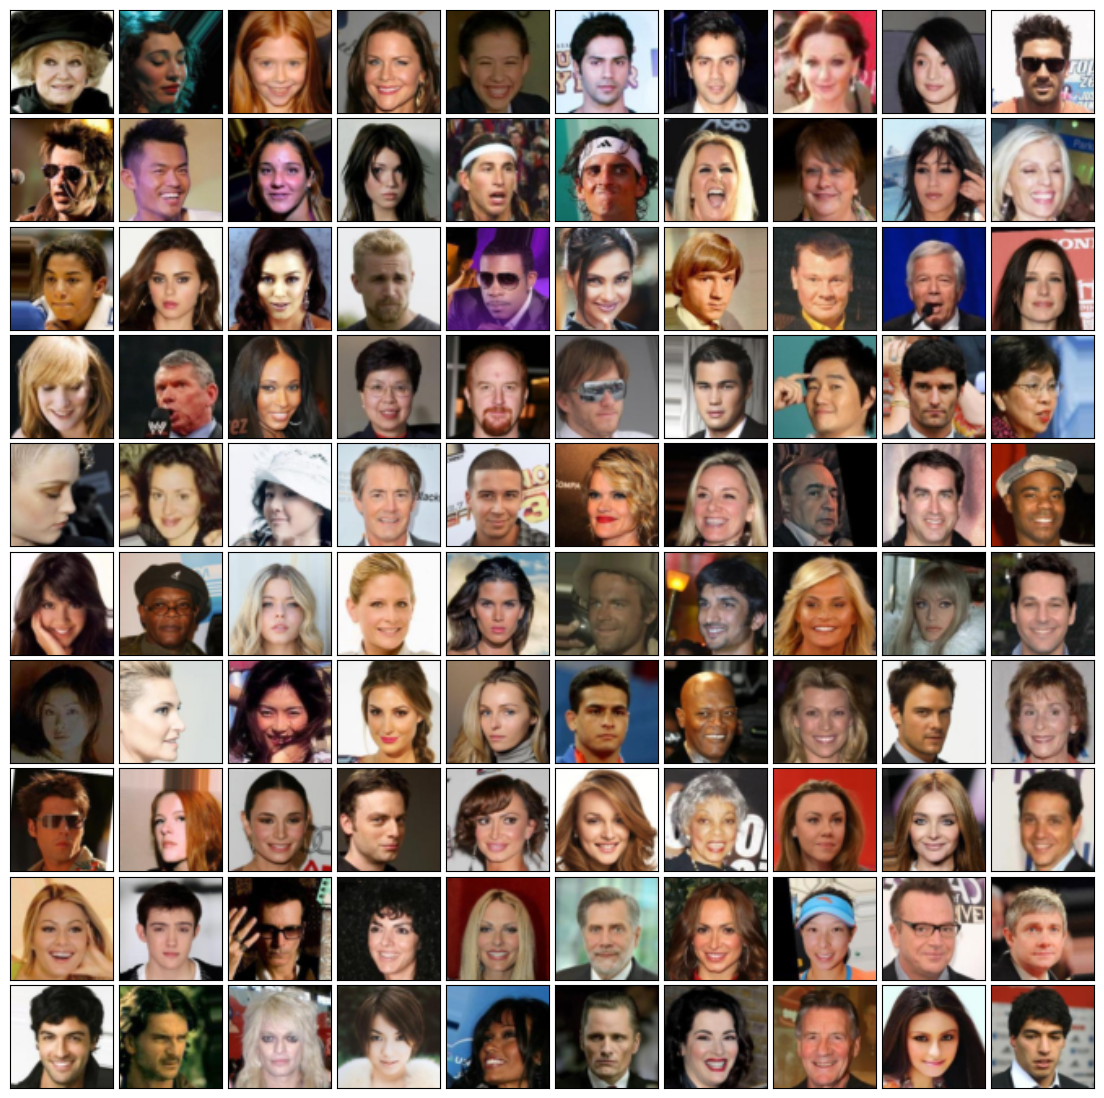

In [22]:
X_test = next(iter(test_loader))[0:100]


fig, axs = plt.subplots(10, 10, figsize=(14, 14), sharex=True, sharey=True,
                        subplot_kw={'xticks': [], 'yticks': []},
                        gridspec_kw=dict(hspace=0.05, wspace=0.05))

for i in range(10):
    for j in range(10):
        idx = i * 10 + j
        axs[i, j].imshow(X_test[idx].reshape(3, 64, 64).permute(1, 2, 0).detach().numpy(), interpolation='bilinear')

plt.savefig('/content/Uniform-Autoencoder-with-Latent-Flow-Matching/results/celebA/celebA_test_verisi_original.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

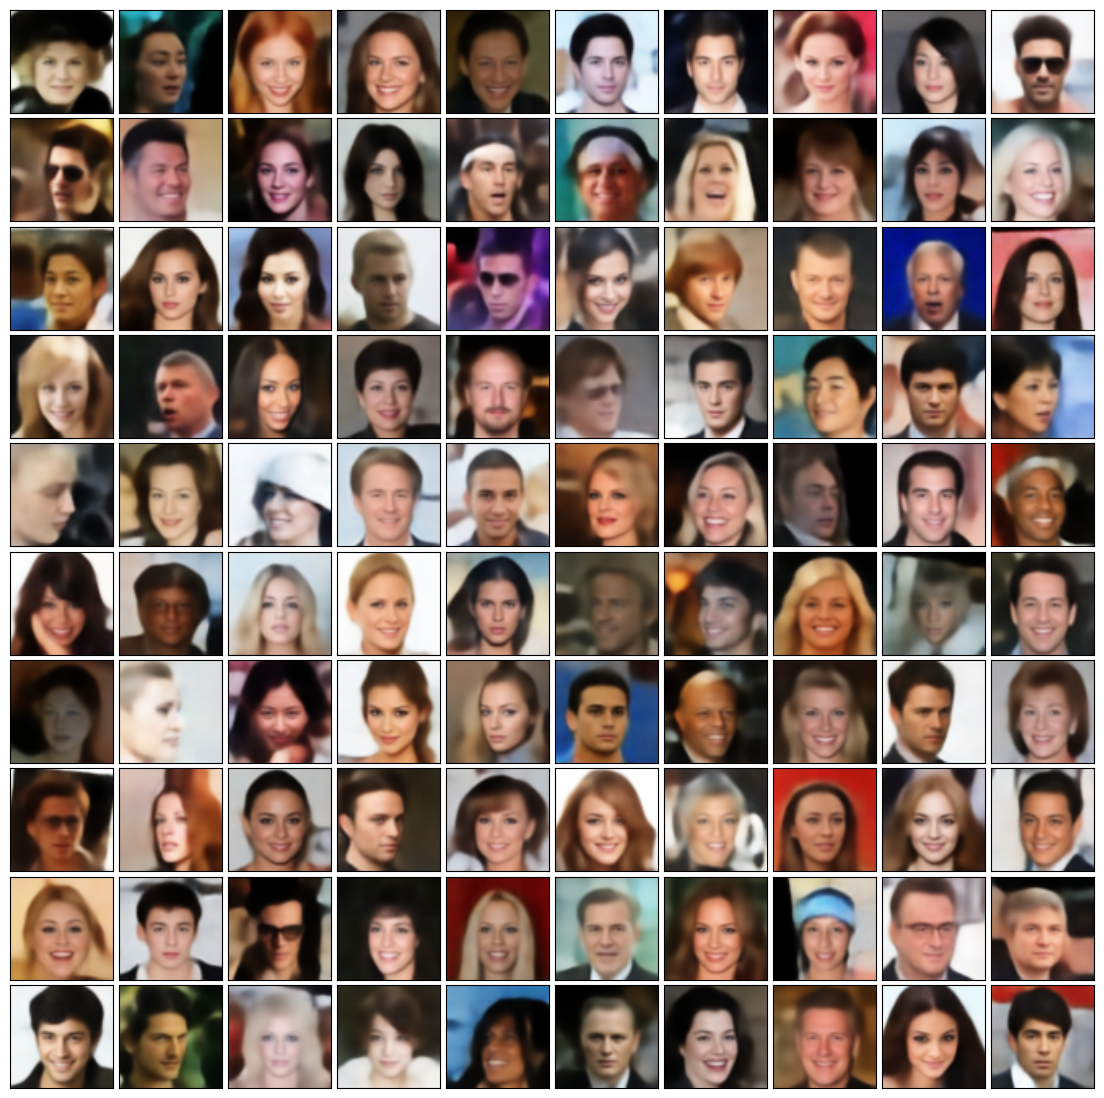

In [23]:
X_test = next(iter(test_loader))[0:100]

# Prediction
z, x_hat = model_eval(X_test)


fig, axs = plt.subplots(10, 10, figsize=(14, 14), sharex=True, sharey=True,
                        subplot_kw={'xticks': [], 'yticks': []},
                        gridspec_kw=dict(hspace=0.05, wspace=0.05))

for i in range(10):
    for j in range(10):
        idx = i * 10 + j
        axs[i, j].imshow(x_hat[idx].reshape(3, 64, 64).permute(1, 2, 0).detach().numpy(), interpolation='bilinear')

plt.savefig('/content/Uniform-Autoencoder-with-Latent-Flow-Matching/results/celebA/celebA_test_verisi_production.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

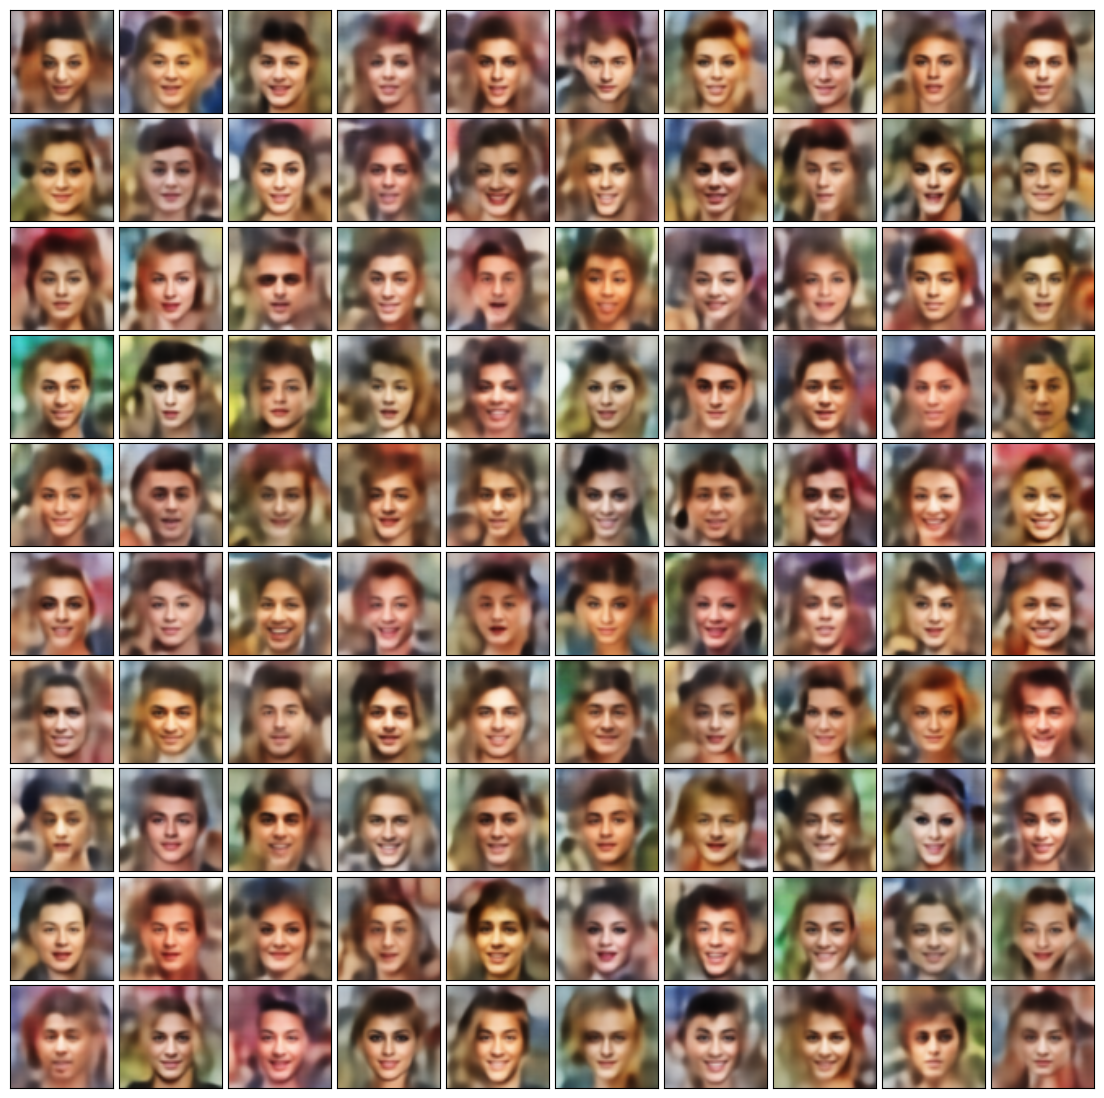

In [24]:
# Sample from a uniform latent distribution
uniform_dist = torch.distributions.uniform.Uniform(low=torch.zeros(1024), high=torch.ones(1024))
latent_samples = uniform_dist.sample((100,))

# Decode
x_hat = model_eval.decoder(latent_samples).view(-1, 3, 64, 64)

# Plot
fig, axs = plt.subplots(10, 10, figsize=(14, 14), sharex=True, sharey=True,
                        subplot_kw={'xticks': [], 'yticks': []},
                        gridspec_kw=dict(hspace=0.05, wspace=0.05))

for i, ax in enumerate(axs.flat):
    img = x_hat[i].reshape(3, 64, 64).permute(1, 2, 0).detach().numpy()
    ax.imshow(img, interpolation='bilinear')

plt.savefig('/content/Uniform-Autoencoder-with-Latent-Flow-Matching/results/celebA/celebA_data_uretimi_from_latent.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

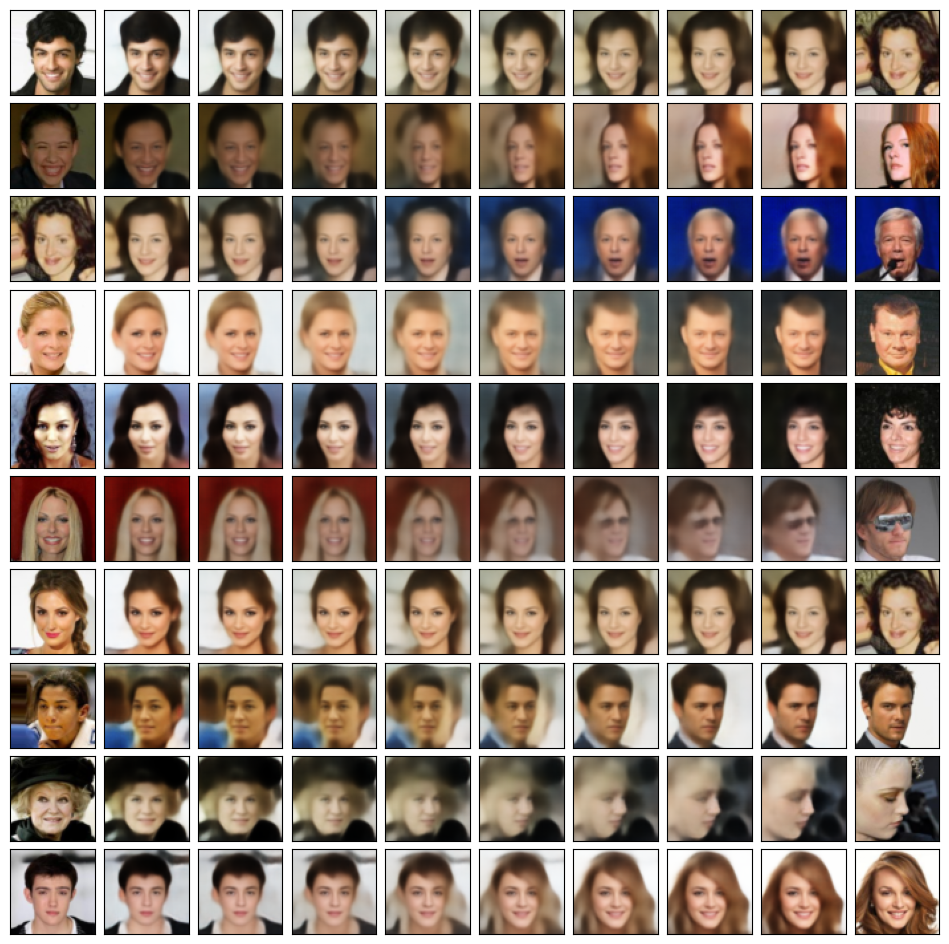

In [25]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def celeba_interpolation_random_pairs(model, X_tensor, device='cpu'):
    model.to(device)
    model.eval()

    fig, axes = plt.subplots(10, 10, figsize=(12, 12),
                             subplot_kw={'xticks': [], 'yticks': []},
                             gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

    total_samples = len(X_tensor)

    for row in range(10):
        # Select two random samples
        idx1, idx2 = np.random.choice(total_samples, size=2, replace=False)
        img1 = X_tensor[idx1].unsqueeze(0).to(device)  # [1, 3, 64, 64]
        img2 = X_tensor[idx2].unsqueeze(0).to(device)

        with torch.no_grad():
            z1 = model.encoder(img1)
            z2 = model.encoder(img2)
            decoded_img1 = model.decoder(z1).squeeze(0).cpu()
            decoded_img2 = model.decoder(z2).squeeze(0).cpu()

        # 1. Original img1
        axes[row, 0].imshow(img1.squeeze(0).cpu().permute(1, 2, 0).clip(0, 1).numpy())

        # 2. Decoded img1
        axes[row, 1].imshow(decoded_img1.permute(1, 2, 0).clip(0, 1).numpy())

        # interpolation
        for i in range(6):
            alpha = (i + 1) / 7.0
            z_interp = (1 - alpha) * z1 + alpha * z2
            interp_img = model.decoder(z_interp).squeeze(0).cpu()
            axes[row, 2 + i].imshow(interp_img.permute(1, 2, 0).clip(0, 1).detach().numpy())

        # 9. Decoded img2
        axes[row, 8].imshow(decoded_img2.permute(1, 2, 0).clip(0, 1).numpy())

        # 10. Orijinal img2
        axes[row, 9].imshow(img2.squeeze(0).cpu().permute(1, 2, 0).clip(0, 1).numpy())

    plt.savefig('/content/Uniform-Autoencoder-with-Latent-Flow-Matching/results/celebA/celeba_interpolation_random_pairs.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.show()

celeba_interpolation_random_pairs(model_eval, X_test, device='cpu')